In [1]:
# !conda install -c conda-forge librosa

# !conda install tqdm

import torch as ch
import torch.nn as nn
import torch.functional as F
import torch.utils.data as Data

import numpy as np
import pandas as pd
import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline

import os
import string
import librosa
import tqdm
import shutil
# !pip install lws
import lws
import IPython.display as ipd
from importlib import reload

import utils
reload(utils)
import hyperparams
reload(hyperparams)
import datasets
reload(datasets)
import dcttsModel
reload(dcttsModel)

<module 'dcttsModel' from '/home/aduriseti/tts/ettts_master/dcttsModel.py'>

In [2]:
dev = ch.device('cuda:0' if ch.cuda.is_available() else 'cpu')
if ch.cuda.is_available():
    ch.multiprocessing.set_start_method("spawn",force=True)

In [3]:
# params = hyperparams.Hyperparams()
ssrnParams = hyperparams.Hyperparams(sep=1,pad=None,chunk=None)
text2MelParams = hyperparams.Hyperparams(sep=0,pad=2)
ssrn = dcttsModel.SSRN(ssrnParams).to(dev)
text2Mel = dcttsModel.Text2Mel(text2MelParams).to(dev)

# print tunable hyperparams
print('TEXT2MEL HYPERPARAMS',text2MelParams.paramDict)
print('SSRN HYPERPARAMS',ssrnParams.paramDict)
[sum(np.prod(p.size()) for p in m.parameters()) for m in (text2Mel,ssrn)]


TEXT2MEL HYPERPARAMS {'sep': 0, 'alpha': 1, 'dropout': 0.05, 'norm': 2, 'lr': 0.001, 'chunk': 1, 'pad': 2, 'reversedDilation': 0}
SSRN HYPERPARAMS {'sep': 1, 'alpha': 1, 'dropout': 0.05, 'norm': 2, 'lr': 0.001, 'reversedDilation': 0}


[23949552, 24980141]

In [4]:
class DbinLoss(ch.nn.Module):
    def __init__(self):
        super(DbinLoss,self).__init__()
    
    def forward(self,Yhat,Y):
        EPS = 1e-12
        elLoss = -(Y*ch.log(Yhat+EPS)+(1-Y)*ch.log(1-Yhat+EPS))
#         return elLoss.view(elLoss.shape[0],-1).mean(1)
        return elLoss.mean()

class GAttLoss(ch.nn.Module):
    def __init__(self):
        super(GAttLoss,self).__init__()
            
    def forward(self,A,I):
        b,N,T = A.shape
        assert I.shape == (b,)
        if text2MelParams.pad == 2:
            W = ch.Tensor([[[np.e**(-(n/N-(t-i)/T)**2 / (2*text2MelParams.g**2)) 
                             for t in range(1,T+1)] 
                            for n in range(1,N+1)]
                           for i in range(b)])
        else:
            W = ch.Tensor([[np.e**(-(n/N-t/T)**2 / (2*text2MelParams.g**2)) 
                             for t in range(1,T+1)] 
                            for n in range(1,N+1)])
        W = W.to(dev)
        return ((1-W)*A).mean()



L1Fun = ch.nn.L1Loss()
BCEFun = ch.nn.BCELoss()
def SpecLossFun(Shat,S): return L1Fun(Shat,S) + BCEFun(Shat,S)
DbinFun = DbinLoss()
GAttFun = GAttLoss()

In [5]:
def text2MelLossFun(text2Mel,batch):
    bL,bS,_,bI = batch
    Shat,A = text2Mel(bL,bS)
    melLoss = SpecLossFun(Shat[:,:,:-text2Mel.params.chunk],bS[:,:,text2Mel.params.chunk:])
#     print(bI)
    attLoss = GAttFun(A,bI)
    return melLoss + attLoss

def text2MelDispFun(text2Mel,batch):
    bL,bS,bY,i = [t[0:1] for t in batch] # only use first element of batch
    print([bL.shape,bS.shape,bY.shape,i.shape])
    print('LOSS:',text2MelLossFun(text2Mel,batch).item())
    Shat,A = text2Mel(bL,bS)
    bL,bS,Shat,A,bY,i = [t[0].cpu().detach().numpy() for t in (bL,bS,Shat,A,bY,i)]
    print('PAD INDEX',i)
    print('TEXT',"".join(text2Mel.params.i2c[c] for c in bL))
    plt.imshow(bS,cmap='gray')
    plt.show()
    plt.imshow(Shat,cmap='gray')
    plt.show()
    plt.imshow(A,cmap='gray')
    plt.show()

In [6]:
text2MelParams = hyperparams.Hyperparams(sep=0,pad=0)
# nWorkers = 8 if ch.cuda.is_available() else 0
nWorkers = 6 if ch.cuda.is_available() else 0
text2MelLoader = Data.DataLoader(datasets.LJSpeechDataset(ttmel=1,params=text2MelParams),
                                 batch_size=16,
                                 shuffle=True,
                                 num_workers=nWorkers)
text2Mel = dcttsModel.Text2Mel(text2MelParams).to(dev)
text2MelOpt = ch.optim.Adam(text2Mel.parameters(),lr=text2MelParams.lr,
                            betas=(text2MelParams.b1,text2MelParams.b2),
                            eps=text2MelParams.eps)
text2MelWrapper = utils.ModelWrapper(network=text2Mel,optimizer=text2MelOpt,
                                     lossFun=text2MelLossFun,loader=text2MelLoader,
                                     modelName='text2Mel',dev=dev,dispFun=text2MelDispFun)

INITIALIZED text2Mel WITH HYPERPARAMS {'sep': 0, 'alpha': 1, 'dropout': 0.05, 'norm': 2, 'lr': 0.001, 'chunk': 1, 'pad': 0, 'reversedDilation': 0}
TOTAL PARAM COUNT 23949552


In [7]:
text2MelWrapper.load()

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
LOADED EPOCH 1, LOSS 0.04672361437175701, BEST LOSS 0.04672361437175701 FROM ./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar


EPOCH 1



epoch 1 total 0.033307902678958515
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.03175370395183563
PAD INDEX 0
TEXT in this convulsive struggle for bare existence people fought fiercely with one another, and the weakest, of course the women, went under.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


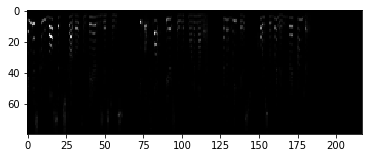

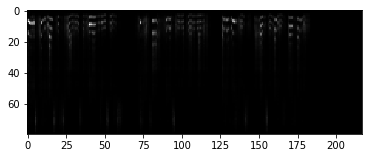

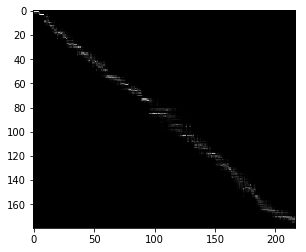

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 2, LOSS 0.033307902678958515, BEST LOSS 0.033307902678958515 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 2



epoch 2 total 0.032482382101910325
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.028805652633309364
PAD INDEX 0
TEXT he continued to be concerned about his undesirable discharge. it is clear that he thought he had been unjustly treated.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


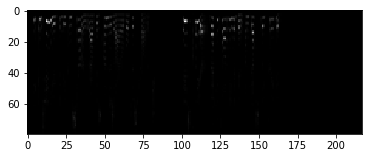

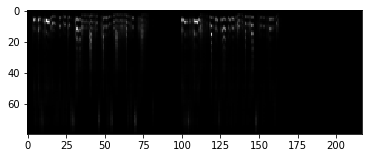

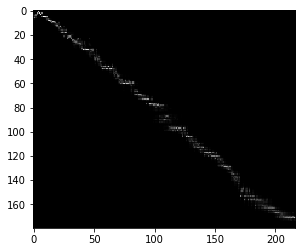

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 3, LOSS 0.032482382101910325, BEST LOSS 0.032482382101910325 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 3



epoch 3 total 0.03200716475831039
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.028503291308879852
PAD INDEX 0
TEXT two cups of fresh milk slightly warmed.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


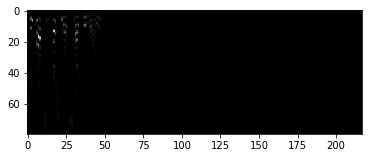

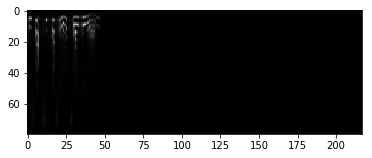

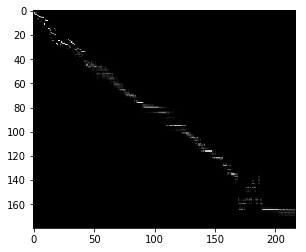

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 4, LOSS 0.03200716475831039, BEST LOSS 0.03200716475831039 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 4



epoch 4 total 0.031568367884897475
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.02761121653020382
PAD INDEX 0
TEXT cover your hair entirely with a handkerchief or sweeping cap.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


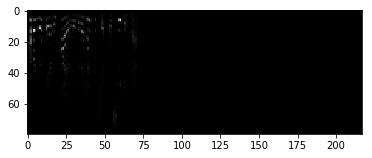

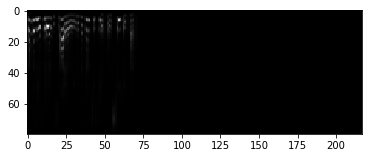

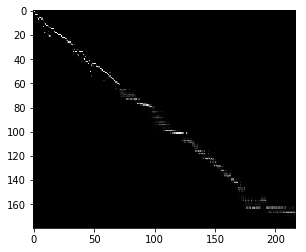

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 5, LOSS 0.031568367884897475, BEST LOSS 0.031568367884897475 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 5



epoch 5 total 0.031070310653034432
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.032745543867349625
PAD INDEX 0
TEXT end quote. hidell was a fictitious president of an organization of which oswald was the only member.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


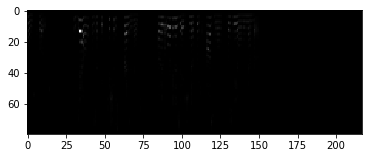

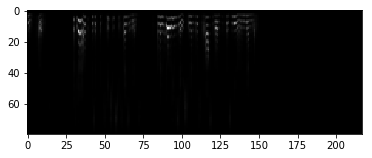

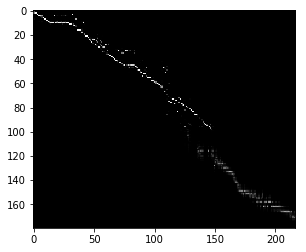

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 6, LOSS 0.031070310653034432, BEST LOSS 0.031070310653034432 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 6



epoch 6 total 0.030480777953209272
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.024831674993038177
PAD INDEX 0
TEXT the mail-order coupon listed the purchaser as "a. j. hidell age twenty-eight"NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


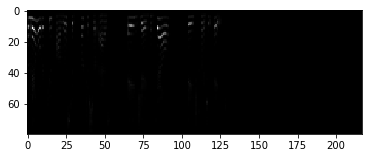

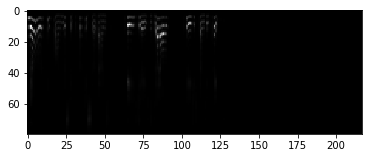

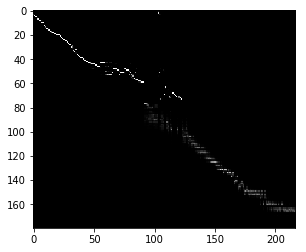

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 7, LOSS 0.030480777953209272, BEST LOSS 0.030480777953209272 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 7



epoch 7 total 0.03003506898713201
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.031632132828235626
PAD INDEX 0
TEXT a witness deposed to meeting hocker, soon after the cries of murder were heard,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


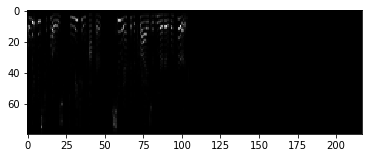

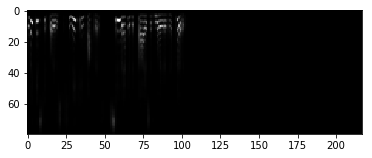

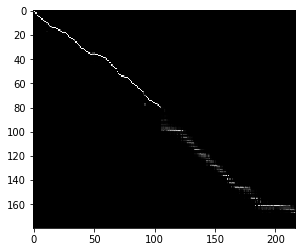

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 8, LOSS 0.03003506898713201, BEST LOSS 0.03003506898713201 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 8



epoch 8 total 0.02968244536209907
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.028360515832901
PAD INDEX 0
TEXT of his concomitant hatred of the united states, which was most clearly expressed in his november twenty-six,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


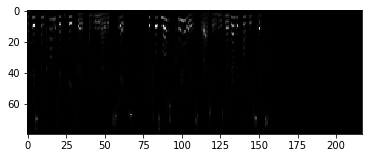

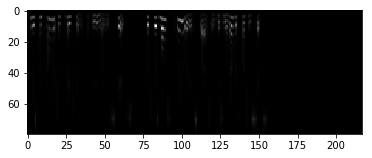

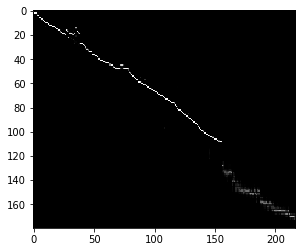

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 9, LOSS 0.02968244536209907, BEST LOSS 0.02968244536209907 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 9



epoch 9 total 0.029396027068037595
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.032953280955553055
PAD INDEX 0
TEXT nebuchadnezzar says that he built it of burned bricks, but only sun-dried bricks laid in mud now appear.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


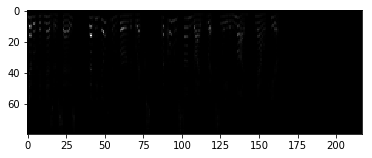

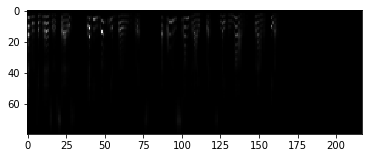

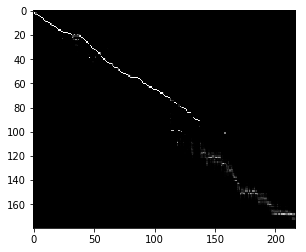

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 10, LOSS 0.029396027068037595, BEST LOSS 0.029396027068037595 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 10



epoch 10 total 0.029133524103507176
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.027517110109329224
PAD INDEX 0
TEXT the evidence was corroborated by that of many of the victims who had acted as messengers,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


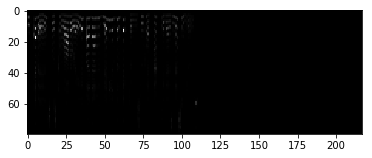

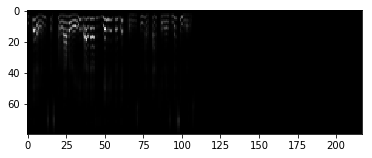

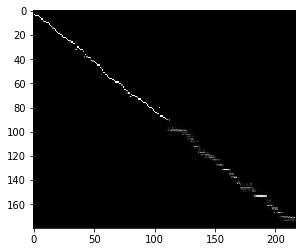

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 11, LOSS 0.029133524103507176, BEST LOSS 0.029133524103507176 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 11



epoch 11 total 0.02888291358336139
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.0176628939807415
PAD INDEX 0
TEXT while calcraft was in office other aspirants to fame appeared in the field.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


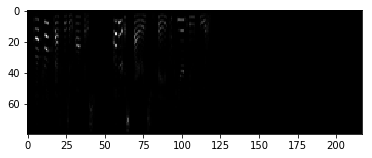

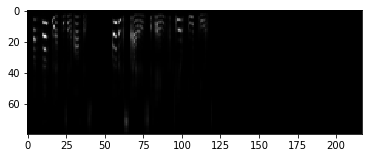

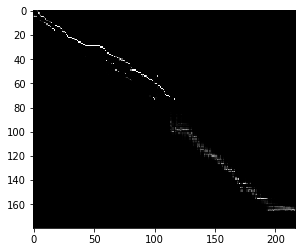

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 12, LOSS 0.02888291358336139, BEST LOSS 0.02888291358336139 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 12



epoch 12 total 0.02866822065535321
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.025055857375264168
PAD INDEX 0
TEXT this generally produces instantaneous death, although cases where complete fracture of the spinal cord occurred are said to be rare.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


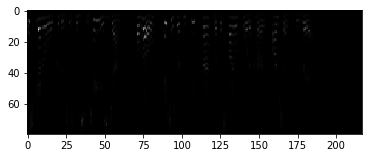

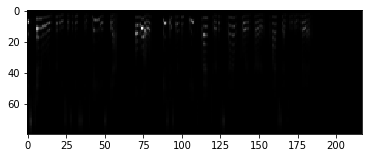

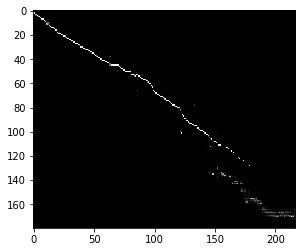

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 13, LOSS 0.02866822065535321, BEST LOSS 0.02866822065535321 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 13



epoch 13 total 0.028469402523739123
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.027549173682928085
PAD INDEX 0
TEXT in the second edition of the "regne animal," published in eighteen twenty-eight,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


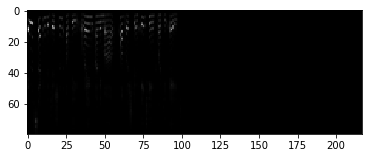

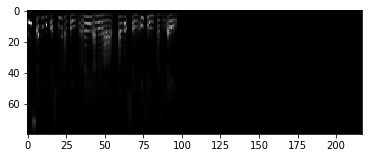

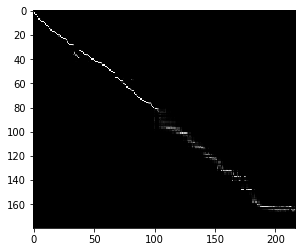

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 14, LOSS 0.028469402523739123, BEST LOSS 0.028469402523739123 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 14



epoch 14 total 0.02829024010240587
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.03479166328907013
PAD INDEX 0
TEXT and had he but been able to remove its iron bars, he might have descended into newgate street by means of a rope ladder.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


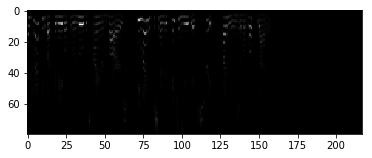

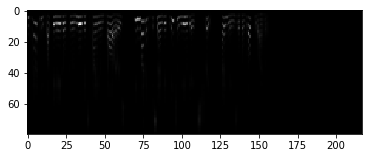

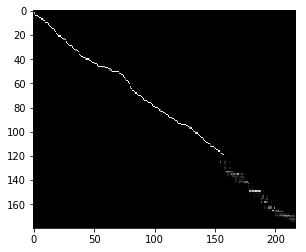

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 15, LOSS 0.02829024010240587, BEST LOSS 0.02829024010240587 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 15



epoch 15 total 0.02810234203100649
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.02616560272872448
PAD INDEX 0
TEXT as he experienced successive failures in his jobs, in his political activity, and in his personal relationships.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


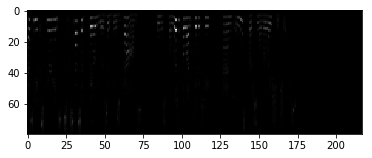

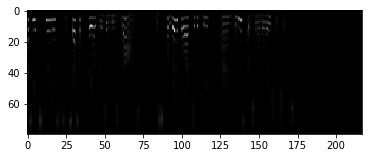

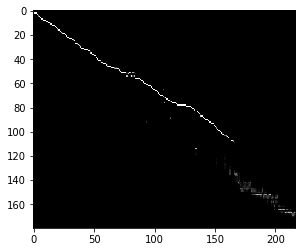

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 16, LOSS 0.02810234203100649, BEST LOSS 0.02810234203100649 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 16



epoch 16 total 0.027944506935552876
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.030187735334038734
PAD INDEX 0
TEXT oswald had a highly exaggerated sense of his own importance, but he had failed at almost everything he had ever tried to do.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


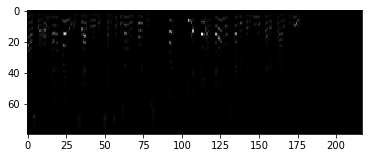

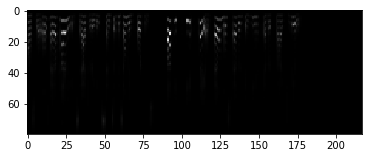

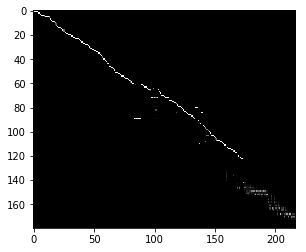

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 17, LOSS 0.027944506935552876, BEST LOSS 0.027944506935552876 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 17



epoch 17 total 0.02778770101270569
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.028140760958194733
PAD INDEX 0
TEXT the eyes of the future became the eyes of god.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


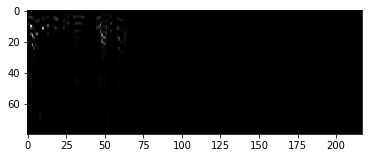

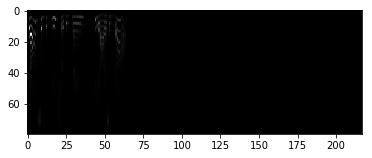

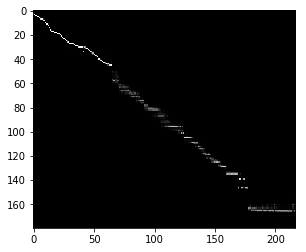

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 18, LOSS 0.02778770101270569, BEST LOSS 0.02778770101270569 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 18



epoch 18 total 0.027662718646339516
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.0399659126996994
PAD INDEX 0
TEXT i know of no test by which the reaction of the leaves of the sundew and of other plants to stimuli, so fully and carefully studied by mr. darwin,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


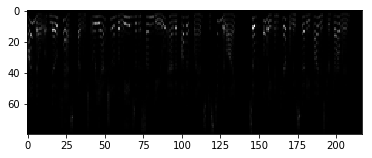

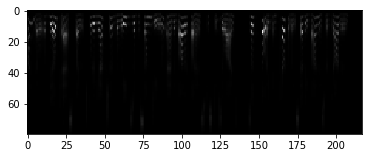

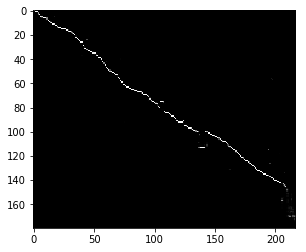

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 19, LOSS 0.027662718646339516, BEST LOSS 0.027662718646339516 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 19



epoch 19 total 0.027519364260248282
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.028553975746035576
PAD INDEX 0
TEXT time has dealt even less kindly with it, for it may be traced only for the distance of about a mile along its eastern side.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


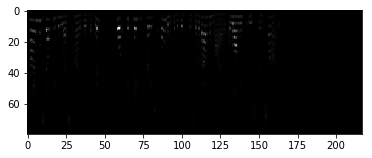

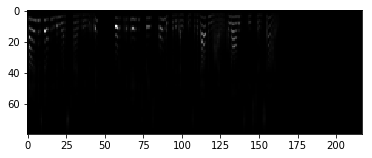

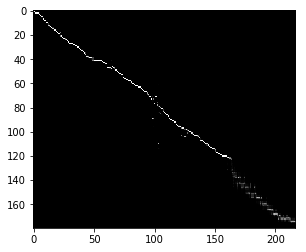

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 20, LOSS 0.027519364260248282, BEST LOSS 0.027519364260248282 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 20



epoch 20 total 0.02739891192194686
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.032101668417453766
PAD INDEX 0
TEXT on the day of the assassination, the dallas police obtained a sample of wrapping paper and tapeNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


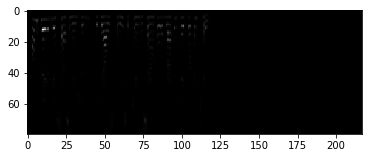

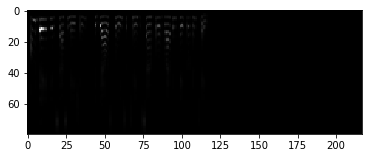

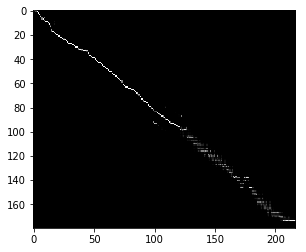

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 21, LOSS 0.02739891192194686, BEST LOSS 0.02739891192194686 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 21



epoch 21 total 0.027274599098669947
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.023167528212070465
PAD INDEX 0
TEXT but i do not believe any intelligent observer can accuse england of undue orthodoxy in the present emergency.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


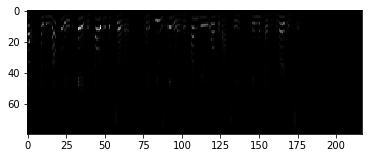

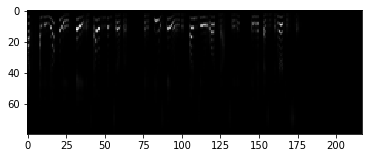

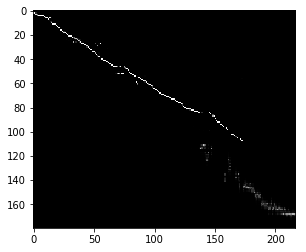

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 22, LOSS 0.027274599098669947, BEST LOSS 0.027274599098669947 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 22



epoch 22 total 0.027161945805731995
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.02551650069653988
PAD INDEX 0
TEXT it was, however, pretty clear that this victim, like preceding ones, had been lured to nova scotia gardens, and there drugged with a large dose of laudanum.NNNNNNNNNNNNNNNNNNNNNNNN


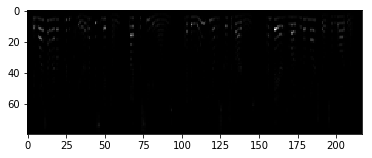

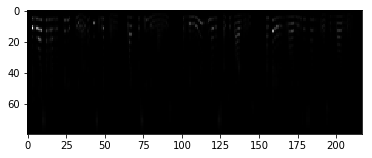

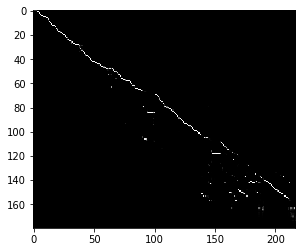

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 23, LOSS 0.027161945805731995, BEST LOSS 0.027161945805731995 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 23



epoch 23 total 0.02706059687562398
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.027903975918889046
PAD INDEX 0
TEXT special agent youngblood learned from mrs. johnson the location of her two daughtersNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


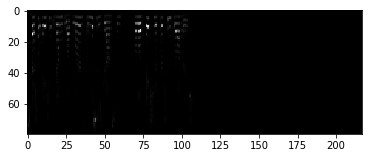

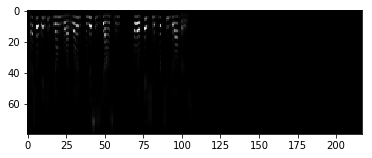

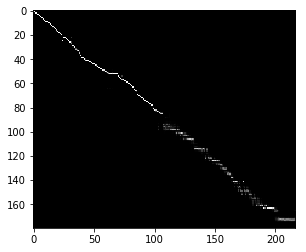

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 24, LOSS 0.02706059687562398, BEST LOSS 0.02706059687562398 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 24



epoch 24 total 0.026948426726427097
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.016674106940627098
PAD INDEX 0
TEXT the number of justices has been changed several times before,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


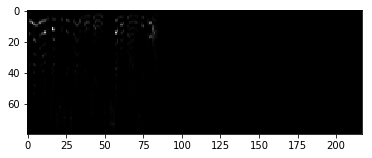

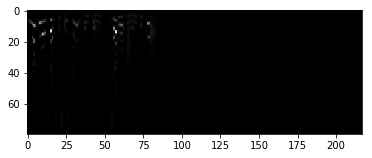

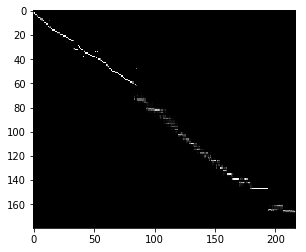

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 25, LOSS 0.026948426726427097, BEST LOSS 0.026948426726427097 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 25



epoch 25 total 0.026879817175108994
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.031191429123282433
PAD INDEX 0
TEXT in many others there were no infirmaries, no places set apart for the confinement of prisoners afflicted with dangerous and infectious disorders.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


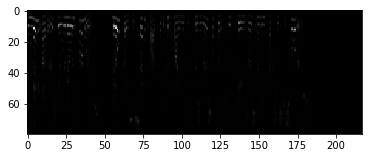

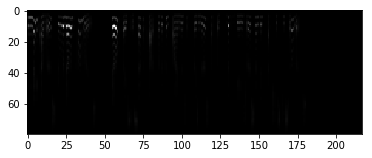

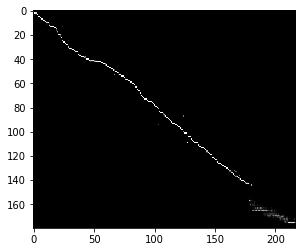

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 26, LOSS 0.026879817175108994, BEST LOSS 0.026879817175108994 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 26



epoch 26 total 0.026772071651891986
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.016587011516094208
PAD INDEX 0
TEXT the bottom of the palm rested on the box.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


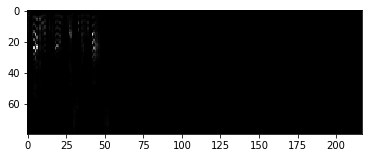

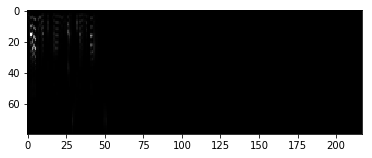

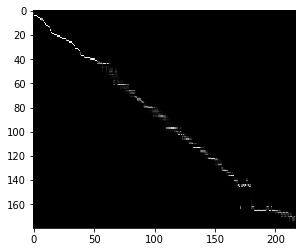

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 27, LOSS 0.026772071651891986, BEST LOSS 0.026772071651891986 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 27



epoch 27 total 0.026696158222742936
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.022854981943964958
PAD INDEX 0
TEXT with the amelioration of the criminal code, other cruel concomitants of execution also disappeared.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


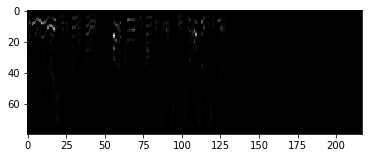

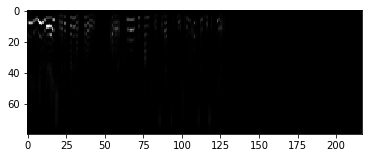

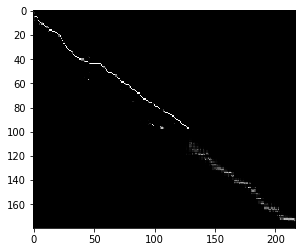

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 28, LOSS 0.026696158222742936, BEST LOSS 0.026696158222742936 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 28



epoch 28 total 0.02661297994651901
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.017255816608667374
PAD INDEX 0
TEXT there was little conversation between them on the way home.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


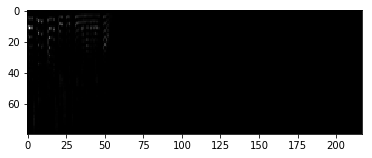

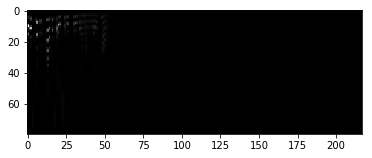

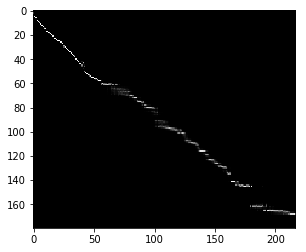

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 29, LOSS 0.02661297994651901, BEST LOSS 0.02661297994651901 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 29



epoch 29 total 0.026553712245910913
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.03592940419912338
PAD INDEX 0
TEXT he married a lady also belonging to the society of friends, who brought him a large fortune, which, and his own money, he put into a city firm,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


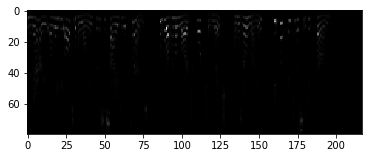

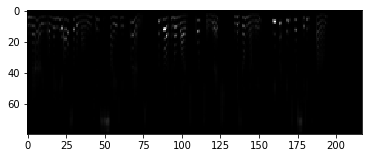

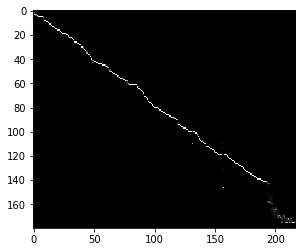

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 30, LOSS 0.026553712245910913, BEST LOSS 0.026553712245910913 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 30



epoch 30 total 0.02648643292208661
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.03523140028119087
PAD INDEX 0
TEXT and having got from the falling drop to the firm part of the platform, he nearly succeeded in tearing the handkerchief from his eyes.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


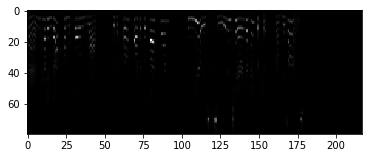

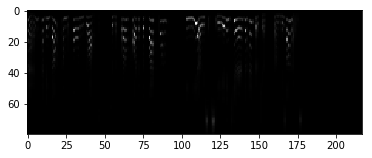

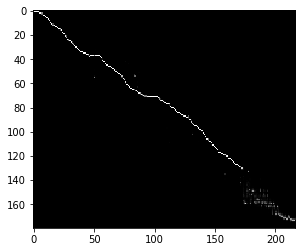

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 31, LOSS 0.02648643292208661, BEST LOSS 0.02648643292208661 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 31


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 34 total 0.026216777152757147
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.027198879048228264
PAD INDEX 0
TEXT mrs. kennedy and the attorney general,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


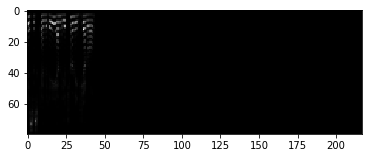

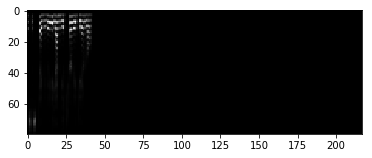

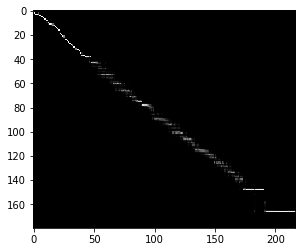

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 35, LOSS 0.026216777152757147, BEST LOSS 0.026216777152757147 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 35



epoch 35 total 0.026167152721935243
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.03022090345621109
PAD INDEX 0
TEXT these words were also in the handwriting of lee harvey oswald.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


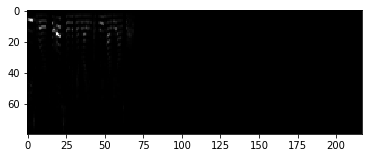

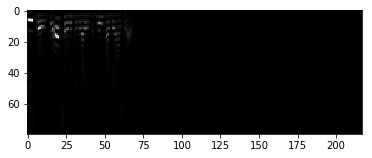

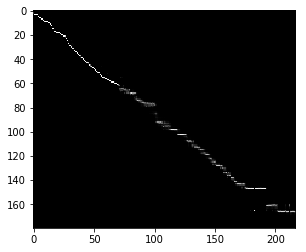

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 36, LOSS 0.026167152721935243, BEST LOSS 0.026167152721935243 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 36


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 39 total 0.02593979419334166
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.013830280862748623
PAD INDEX 0
TEXT the remaining five were executed in one batch.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


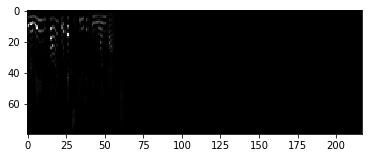

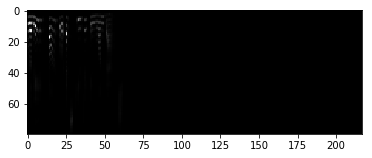

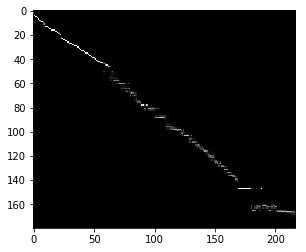

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 40, LOSS 0.02593979419334166, BEST LOSS 0.02593979419334166 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 40



epoch 40 total 0.025903025127724924
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.020897582173347473
PAD INDEX 0
TEXT oswald apparently started reading about communism when he was about fifteen.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


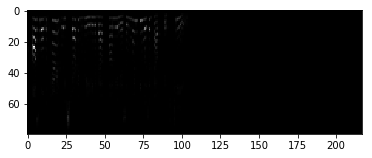

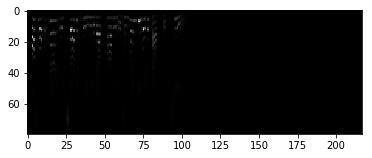

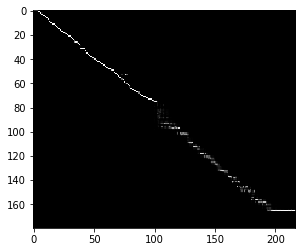

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 41, LOSS 0.025903025127724924, BEST LOSS 0.025903025127724924 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 41


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 44 total 0.025731833284692977
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.023859938606619835
PAD INDEX 0
TEXT he was taken up when still in his teens for stealing a pocketbook, and was sentenced to transportation, but did not get beyond the hulks at chatham.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


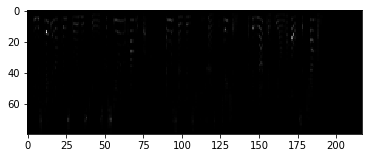

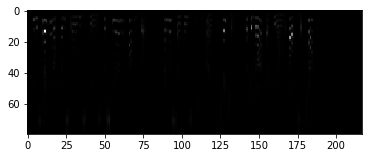

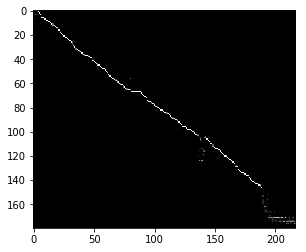

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 45, LOSS 0.025731833284692977, BEST LOSS 0.025731833284692977 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 45



epoch 45 total 0.02569813516213378
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.025997545570135117
PAD INDEX 0
TEXT the walls of the palaces of many of the assyrian kings were lined with great stone slabs engraved with reliefs and sometimes with the portrait of a king.NNNNNNNNNNNNNNNNNNNNNNNNNNN


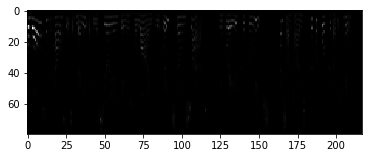

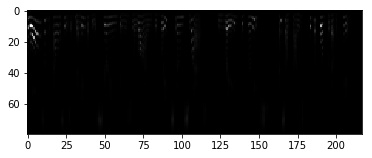

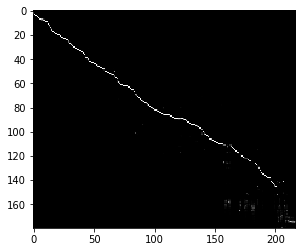

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 46, LOSS 0.02569813516213378, BEST LOSS 0.02569813516213378 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 46


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 49 total 0.025543265164232075
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.016188623383641243
PAD INDEX 0
TEXT like the bible, it ought to be read again and again.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


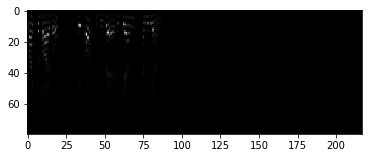

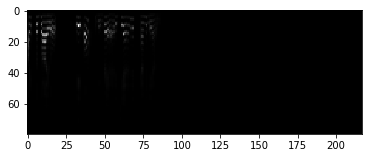

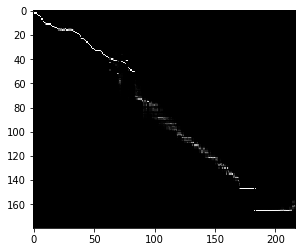

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 50, LOSS 0.025543265164232075, BEST LOSS 0.025543265164232075 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 50



epoch 50 total 0.02551839827045576
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.02422894909977913
PAD INDEX 0
TEXT with such further separation as the justices should deem conducive to good order and discipline.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


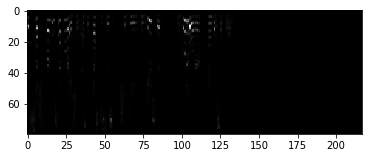

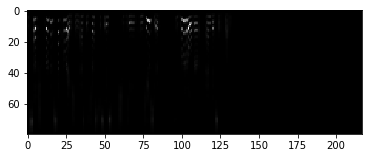

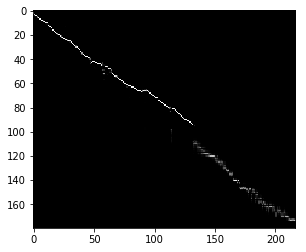

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 51, LOSS 0.02551839827045576, BEST LOSS 0.02551839827045576 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 51


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 54 total 0.025405376824314024
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.025742506608366966
PAD INDEX 0
TEXT the fireside chats of franklin delano roosevelt, by franklin d roosevelt, section six.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


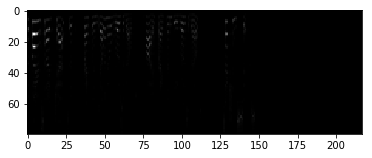

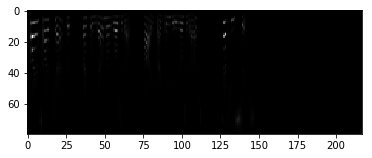

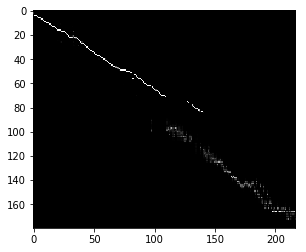

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 55, LOSS 0.025405376824314024, BEST LOSS 0.025405376824314024 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 55



epoch 55 total 0.02537839726558817
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.027537526562809944
PAD INDEX 0
TEXT and carbonic acid containing carbon and oxygen.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


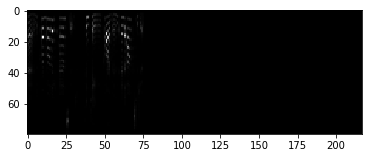

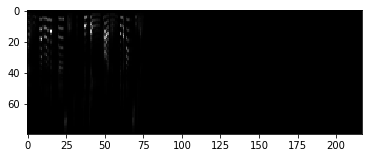

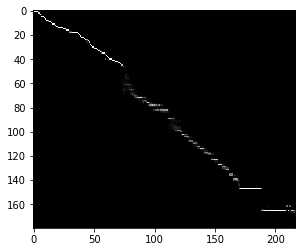

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 56, LOSS 0.02537839726558817, BEST LOSS 0.02537839726558817 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 56


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 59 total 0.025277438259391643
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.031444769352674484
PAD INDEX 0
TEXT when president and mrs. kennedy shook hands with members of the public along the fences surrounding the reception area, they were closely guarded by secret service agentsNNNNNNNNNN


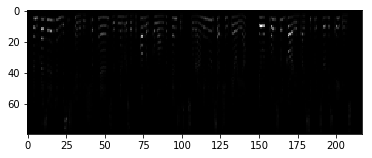

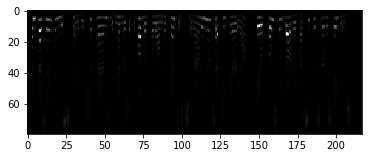

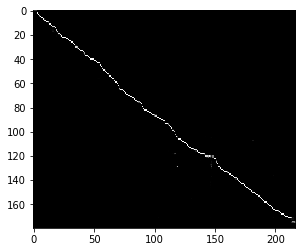

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 60, LOSS 0.025277438259391643, BEST LOSS 0.025277438259391643 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 60



epoch 60 total 0.02526985940092535
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.03891053795814514
PAD INDEX 0
TEXT and direction of the activities of all existing agencies of government which are in a position to and do, furnish informationNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


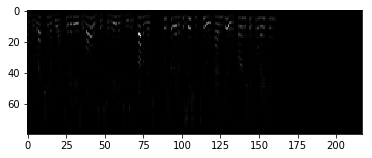

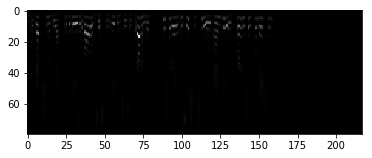

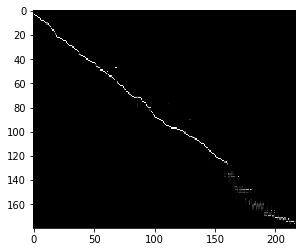

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 61, LOSS 0.02526985940092535, BEST LOSS 0.02526985940092535 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 61


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 63 total 0.02518910279414102
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.0339341014623642
PAD INDEX 0
TEXT it is a quiet crisis. there are no lines of depositors outside closed banks.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


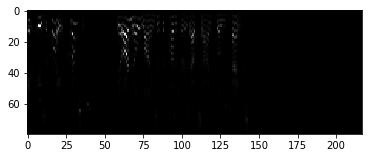

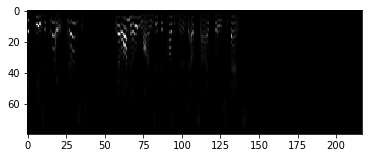

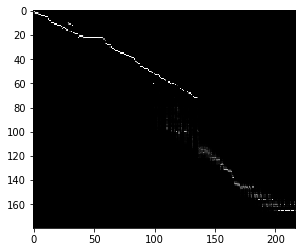

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 64, LOSS 0.02518910279414102, BEST LOSS 0.02518910279414102 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 64



epoch 64 total 0.025170009288547644
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.03925655409693718
PAD INDEX 0
TEXT i come now to the debtors in newgate. the quarters they occupied were divided, as i have said, into three principal divisionsNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


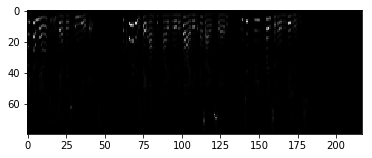

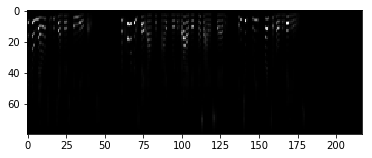

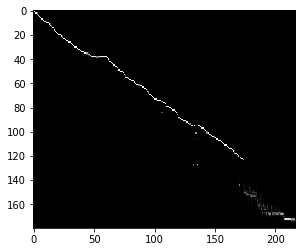

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 65, LOSS 0.025170009288547644, BEST LOSS 0.025170009288547644 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 65



epoch 65 total 0.025135939504339625
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.025833094492554665
PAD INDEX 0
TEXT i now propose that we establish by law an assurance against any such ill-balanced court in the future.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


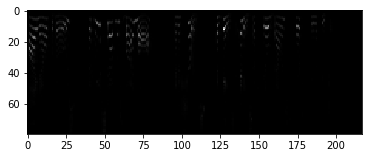

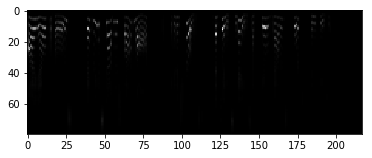

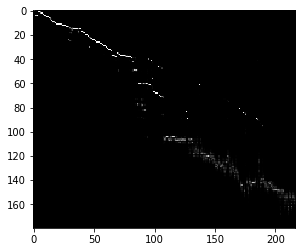

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 66, LOSS 0.025135939504339625, BEST LOSS 0.025135939504339625 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 66


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 69 total 0.025049070696999777
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.01766924187541008
PAD INDEX 0
TEXT bouck explained the failure to try to identify the individuals involved in the stevenson incident after it occurred on the ground thatNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


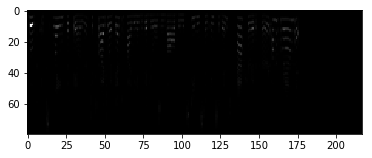

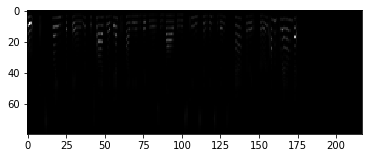

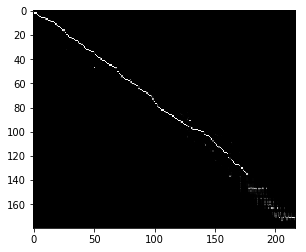

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 70, LOSS 0.025049070696999777, BEST LOSS 0.025049070696999777 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 70



epoch 70 total 0.02503358096217931
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.02210143581032753
PAD INDEX 0
TEXT but who had all the appearance of a careless, thoughtless, happy-go-lucky fellow.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


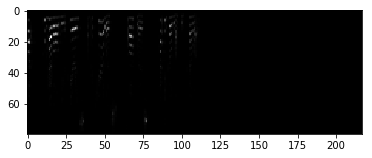

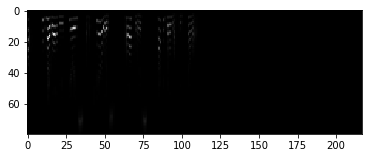

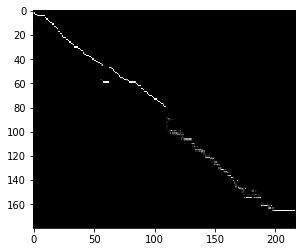

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 71, LOSS 0.02503358096217931, BEST LOSS 0.02503358096217931 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 71


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 71 total 0.025014868025570663
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.02277292124927044
PAD INDEX 0
TEXT the porter asked what he had got, and the answer was, a male subject.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


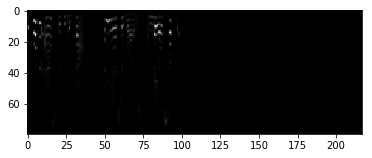

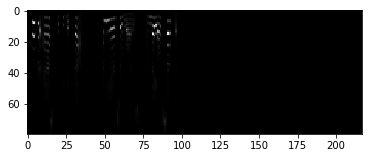

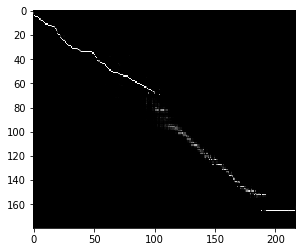

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 72, LOSS 0.025014868025570663, BEST LOSS 0.025014868025570663 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 72



epoch 72 total 0.025006390969032673
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.02768612653017044
PAD INDEX 0
TEXT in order to avoid the traffic hazards which would otherwise exist if right turns were permitted from both main and elm into the freeway.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


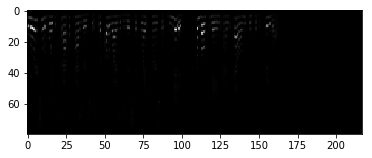

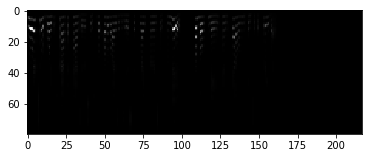

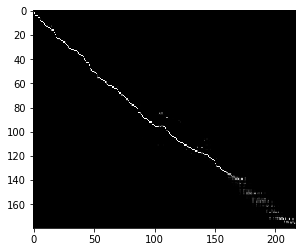

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 73, LOSS 0.025006390969032673, BEST LOSS 0.025006390969032673 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelLast.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar', './text2MelBest.d0db114ac35810d66cf22d3d13d807cf5ec3cb968e3cf54ee66c209661c8b667.chkpt.tar']
EPOCH 73


In [ ]:
text2MelWrapper.train(numEpochs=99)

In [ ]:
text2MelWrapper.load()
plt.plot(text2MelWrapper.lossHist[5:])

In [ ]:
def ssrnLossFun(ssrn,batch):
    _,bS,bY,_ = batch
    Yhat = ssrn(bS)
    return SpecLossFun(Yhat,bY)

def ssrnDispFun(ssrn,batch):
    bL,bS,bY,i = [t[0:1] for t in batch] # only use first element of batch
#     print([t.device for t in batch])
    print('LOSS:',ssrnLossFun(ssrn,batch).item())
    print(bS.shape)
    Yhat = ssrn(bS)
    bL,bS,bY,Yhat,i = [t[0].cpu().detach().numpy() for t in (bL,bS,bY,Yhat,i)]
    print('PAD INDEX',i)
    print('TEXT',"".join(ssrn.params.i2c[c] for c in bL))
    plt.imshow(bS,cmap='gray')
    plt.show()
    plt.imshow(bY,cmap='gray')
    plt.show()
    plt.imshow(Yhat,cmap='gray')
    plt.show()

In [ ]:
ssrnParams = hyperparams.Hyperparams(sep=0,pad=None,reversedDilation=None)
# nWorkers = 8 if ch.cuda.is_available() else 0
nWorkers = 6 if ch.cuda.is_available() else 0
ssrnLoader = Data.DataLoader(datasets.LJSpeechDataset(ttmel=0),
                             batch_size=16,
                             shuffle=True,
                             num_workers=nWorkers)
ssrn = dcttsModel.SSRN(ssrnParams).to(dev)
ssrnOpt = ch.optim.Adam(ssrn.parameters(),lr=ssrnParams.lr,
                        betas=(ssrnParams.b1,ssrnParams.b2),
                        eps=ssrnParams.eps)
ssrnWrapper = utils.ModelWrapper(network=ssrn,optimizer=ssrnOpt,
                                 lossFun=ssrnLossFun,loader=ssrnLoader,
                                 modelName='ssrn',dev=dev,dispFun=ssrnDispFun)

In [ ]:
ssrnWrapper.train(numEpochs=50)